In [45]:
import pandas as pd
import os, glob
import numpy as np
import json
from bokeh.io import show
from bokeh.models import LogColorMapper
from bokeh.palettes import Blues6 as palette
from bokeh.plotting import figure
from bokeh.io import output_notebook

In [27]:
def get_lats_lons(l):
    """function to format latitude and longitude of region's borders
    """
    lats, lons = [], []
    for j in range(len(l[0])):
        lons.append(l[0][j][0])
        lats.append(l[0][j][1])
    return lats, lons

# Load and process data

### Load data fornitori / partecipazioni

In [100]:
dfs = {}
for f in glob.glob('../data/fornitori/*'):
    if f[-3:] == 'csv':
        k = os.path.split(f)[1][:-4]
        df = pd.read_csv(f, encoding='ISO-8859-1')
        if '#Partita_Iva' in df.columns:
            df.rename(columns={'#Partita_Iva': 'Partita_Iva'}, inplace=True)
            df.drop_duplicates('Partita_Iva', inplace=True)
            df.dropna(subset=['Partita_Iva'], inplace=True)
        if '#Denominazione_Iniziativa' in df.columns:
            df.rename(columns={'#Denominazione_Iniziativa': 'Denominazione_Iniziativa'}, inplace=True)
        df = df.drop_duplicates()

        dfs[k] = df

In [101]:
df_f = dfs['fornitori' + str(2020)]
df_p = dfs['partecipazioni' + str(2020)]

In [102]:
df_dp = df_p.groupby('Denominazione_Partecipazione')['Partita_Iva'].count()

In [103]:
df_p.drop(['Identificativo_Lotto', 'Ragione_Sociale'], axis=1, inplace=True)

In [105]:
df_p['Esito_Partecipazione'].value_counts() / len(df_p)

Abilitato             0.990272
Non Aggiudicatario    0.006811
Aggiudicatario        0.002916
Name: Esito_Partecipazione, dtype: float64

### Merge data fornitori / partecipazioni

In [85]:
to_merge = ['Partita_Iva','Nazione_Sede_legale', 'Regione_Sede_legale', 'Provincia_Sede_legale', 'Forma_Societaria']
df_merged = df_p.merge(df_f[to_merge], on='Partita_Iva')
#df_merged.drop('Identificativo_Lotto', axis=1, inplace=True)
df_merged.dropna(inplace=True)

### Sort rows by date

In [86]:
df_merged['Data_Aggiudicazione/Abilitazione'] = pd.to_datetime(df_merged['Data_Aggiudicazione/Abilitazione'],
                                                              format="%d-%m-%Y")

In [87]:
df_merged = df_merged.sort_values('Data_Aggiudicazione/Abilitazione')

### Create year, month and quarter columns

In [88]:
def month_to_quarter(m):
    if m in [1, 2, 3]:
        return 1
    if m in [4, 5, 6]:
        return 2
    if m in [7, 8, 9]:
        return 3
    if m in [10, 11, 12]:
        return 4

In [89]:
df_merged['Year'] = df_merged['Data_Aggiudicazione/Abilitazione'].map(lambda x: x.year)
df_merged['month'] = df_merged['Data_Aggiudicazione/Abilitazione'].map(lambda x: x.month)
df_merged['day'] = df_merged['Data_Aggiudicazione/Abilitazione'].map(lambda x: x.day) 
df_merged['quarter'] = df_merged['month'].apply(lambda x: month_to_quarter(x))

In [90]:
# save df
df_merged.to_csv('../data_processed/df_fornitori.csv', index=False)

In [91]:
df_merged.head()

,Denominazione_Iniziativa,Denominazione_Lotto,Tipo_Strumento,Partita_Iva,Forma_Partecipazione,Denominazione_Partecipazione,Progressivo_Partecipante,Flag_Capogruppo,Esito_Partecipazione,Data_Aggiudicazione/Abilitazione,Nazione_Sede_legale,Regione_Sede_legale,Provincia_Sede_legale,Forma_Societaria,Year,month,day,quarter
1895,SERVIZIO INTEGRATO ENERGIA 2,EMILIA ROMAGNA,Convenzione,03609840370,Operatori Riuniti,RTI - CNS CONSORZIO NAZIONALE DEI SERVIZI SOC....,1,S,Aggiudicatario,2011-01-17,ITALIA,EMILIA ROMAGNA,BOLOGNA,Consorzio fra società cooperative di produzion...,2011,1,17,1
278956,SERVIZIO INTEGRATO ENERGIA 2,EMILIA ROMAGNA,Convenzione,01795380359,Operatori Riuniti,RTI - CNS CONSORZIO NAZIONALE DEI SERVIZI SOC....,1,N,Aggiudicatario,2011-01-17,ITALIA,EMILIA ROMAGNA,REGGIO NELL'EMILIA,Società per Azioni,2011,1,17,1
1894,SERVIZIO INTEGRATO ENERGIA 2,CAMPANIA,Convenzione,03609840370,Operatori Riuniti,RTI - CNS CONSORZIO NAZIONALE DEI SERVIZI SOC....,1,S,Aggiudicatario,2011-01-19,ITALIA,EMILIA ROMAGNA,BOLOGNA,Consorzio fra società cooperative di produzion...,2011,1,19,1
174951,SERVIZIO INTEGRATO ENERGIA 2,"TOSCANA, UMBRIA",Convenzione,04723411007,Operatori Riuniti,"RTI - COFELY ITALIA S.P.A. , ASTRIM S.P.A., MI...",1,N,Aggiudicatario,2011-01-19,ITALIA,LAZIO,ROMA,Società per Azioni,2011,1,19,1
267300,SERVIZIO INTEGRATO ENERGIA 2,"VALLE D'AOSTA, PIEMONTE, LIGURIA",Convenzione,00303020176,Operatori Riuniti,"RTI - A.B.P. NOCIVELLI S.P.A. , M.S.T. MANUTEN...",1,S,Aggiudicatario,2011-01-19,ITALIA,LOMBARDIA,BRESCIA,Società per Azioni,2011,1,19,1


In [92]:
df_merged.columns

Index(['Denominazione_Iniziativa', 'Denominazione_Lotto', 'Tipo_Strumento',
       'Partita_Iva', 'Forma_Partecipazione', 'Denominazione_Partecipazione',
       'Progressivo_Partecipante', 'Flag_Capogruppo', 'Esito_Partecipazione',
       'Data_Aggiudicazione/Abilitazione', 'Nazione_Sede_legale',
       'Regione_Sede_legale', 'Provincia_Sede_legale', 'Forma_Societaria',
       'Year', 'month', 'day', 'quarter'],
      dtype='object')

Abilitato             379163
Aggiudicatario          1106
Non Aggiudicatario         5
Name: Esito_Partecipazione, dtype: int64

# Analysis and visualization

In [69]:
# load saved df
df_merged = pd.read_csv('../data_processed/df_fornitori.csv')

In [70]:
col = 'Esito_Partecipazione'
dummies = pd.get_dummies(df_merged[col], prefix=col)
df_merged = df_merged.merge(dummies, left_index=True, right_index=True)
df_merged.drop(col, axis=1, inplace=True)
df_merged['Esito_Partecipazione_tot'] = df_merged['Esito_Partecipazione_Abilitato'] + df_merged['Esito_Partecipazione_Aggiudicatario'] + df_merged['Esito_Partecipazione_Non Aggiudicatario']

In [71]:
count_by_region = df_merged.groupby('Regione_Sede_legale')['Esito_Partecipazione_tot'].sum()
top = 100
count_by_region.sort_values(ascending=False)[:top].index

Index(['CAMPANIA', 'SICILIA', 'LAZIO', 'PIEMONTE', 'VENETO', 'LOMBARDIA',
       'PUGLIA', 'EMILIA ROMAGNA', 'CALABRIA', 'MARCHE', 'TOSCANA', 'SARDEGNA',
       'ABRUZZO', 'FRIULI VENEZIA GIULIA', 'LIGURIA', 'UMBRIA', 'BASILICATA',
       'TRENTINO ALTO ADIGE', 'MOLISE', 'VALLE D'AOSTA', 'Estero'],
      dtype='object', name='Regione_Sede_legale')

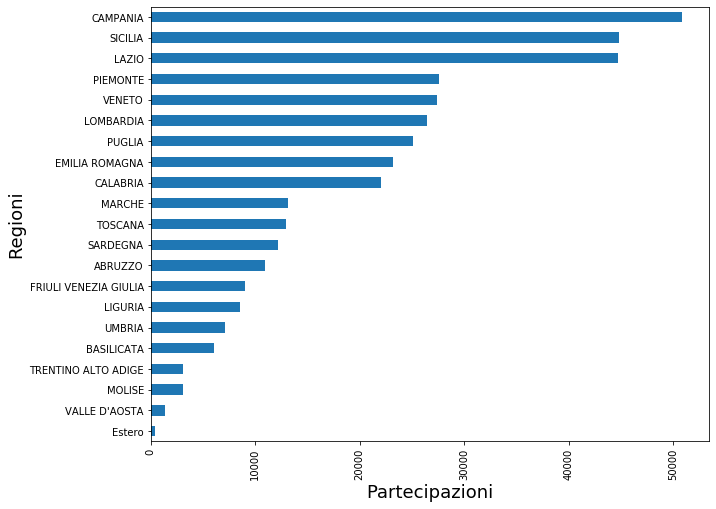

In [72]:
ax = count_by_region[count_by_region.sort_values(ascending=True)[:top].index].plot(figsize=(10, 8), kind='barh')
ax.set_xlabel('Partecipazioni', fontsize=18)
ax.set_ylabel('Regioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

In [74]:
df_merged['Data_Aggiudicazione/Abilitazione'].max()

'2020-03-31'

In [75]:
df_merged.shape

(380274, 21)

In [76]:
df_merged.columns

Index(['Denominazione_Iniziativa', 'Denominazione_Lotto', 'Tipo_Strumento',
       'Partita_Iva', 'Forma_Partecipazione', 'Denominazione_Partecipazione',
       'Progressivo_Partecipante', 'Flag_Capogruppo',
       'Data_Aggiudicazione/Abilitazione', 'Nazione_Sede_legale',
       'Regione_Sede_legale', 'Provincia_Sede_legale', 'Forma_Societaria',
       'Year', 'month', 'day', 'quarter', 'Esito_Partecipazione_Abilitato',
       'Esito_Partecipazione_Aggiudicatario',
       'Esito_Partecipazione_Non Aggiudicatario', 'Esito_Partecipazione_tot'],
      dtype='object')

### Create map with bokeh

In [43]:
# load region's borders
with open('../data/regioni.json', 'r') as f:
    regioni_json = json.load(f)
    f.close()
regioni_json = regioni_json['features']

In [44]:
# format names and borders
regs = {}
for i in range(len(regioni_json)):
    lats, lons = get_lats_lons(regioni_json[i]['geometry']['coordinates'])
    name = regioni_json[i]['properties']['regione']
    if name == 'Emilia-Romagna':
        name = 'Emilia Romagna'
    elif name == 'Friuli-Venezia Giulia':
        name = 'Friuli Venezia Giulia'
    elif name == 'Trentino Alto-Adige':
        name = 'Trentino Alto Adige'
    name = name.upper()
    regs['{}'.format(i)] = {'name': name,
                            'lons': lons,                                       
                            'lats': lats}

In [46]:
output_notebook()
palette = tuple(reversed(palette))

xs = [reg["lons"] for reg in regs.values()]
ys = [reg["lats"] for reg in regs.values()]

names = [reg['name'].upper() for reg in regs.values()]
nb = [count_by_region.to_dict()[name] for name in names]
color_mapper = LogColorMapper(palette=palette)

data=dict(
    x=xs,
    y=ys,
    name=names,
    rate=nb,
)

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="partecipazioni totali per regione", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    tooltips=[
        ("Name", "@name"), ("Partecipazioni", "@rate"), ("(Long, Lat)", "($x, $y)")
    ])
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=data,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

show(p)

Loading BokehJS ...

### Total number of partecipazioni by month

In [47]:
count_by_month = df_merged.groupby(['Year', 'month'])['Esito_Partecipazione_tot'].sum()
count_by_region_month =  df_merged.groupby(['Year', 'month', 'Regione_Sede_legale'])['Esito_Partecipazione_tot'].sum()
count_by_region_month = count_by_region_month.unstack('Regione_Sede_legale').fillna(0)

count_by_quarter = df_merged.groupby(['Year', 'quarter'])['Esito_Partecipazione_tot'].sum()
count_by_region_quarter =  df_merged.groupby(['Year', 'quarter', 'Regione_Sede_legale'])['Esito_Partecipazione_tot'].sum()
count_by_region_quarter = count_by_region_quarter.unstack('Regione_Sede_legale').fillna(0)

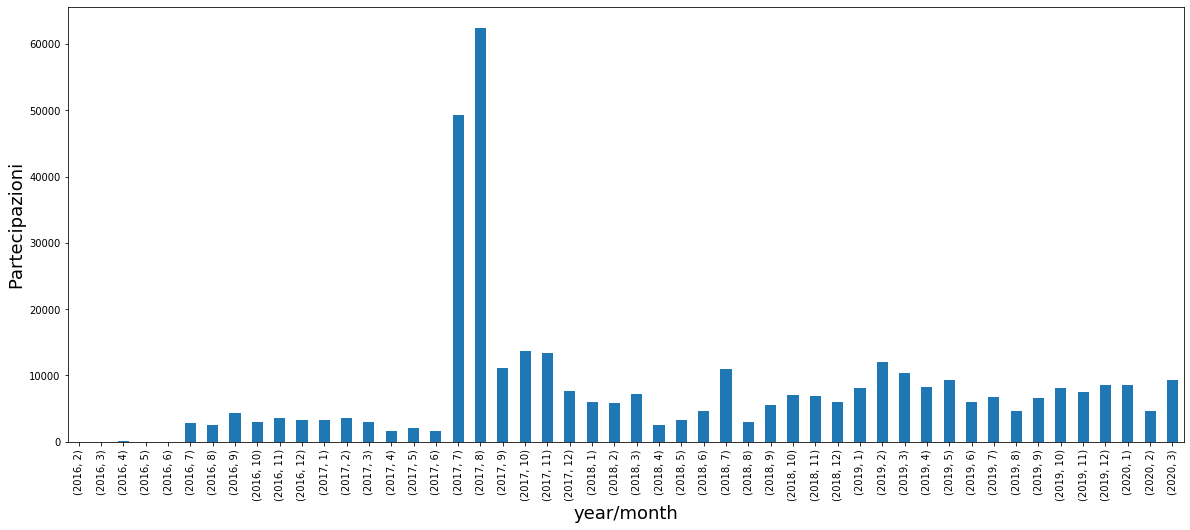

In [48]:
ax = count_by_month[count_by_month.index.get_level_values('Year') >= 2016].plot(linewidth=2, figsize=(20, 8), kind='bar')
ax.set_xlabel('year/month', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

In [49]:
top = 100
count_by_region_month = count_by_region_month[count_by_region_month.sum(axis=0).sort_values(ascending=False)[:top].index]

Text(0, 0.5, 'Partecipazioni')

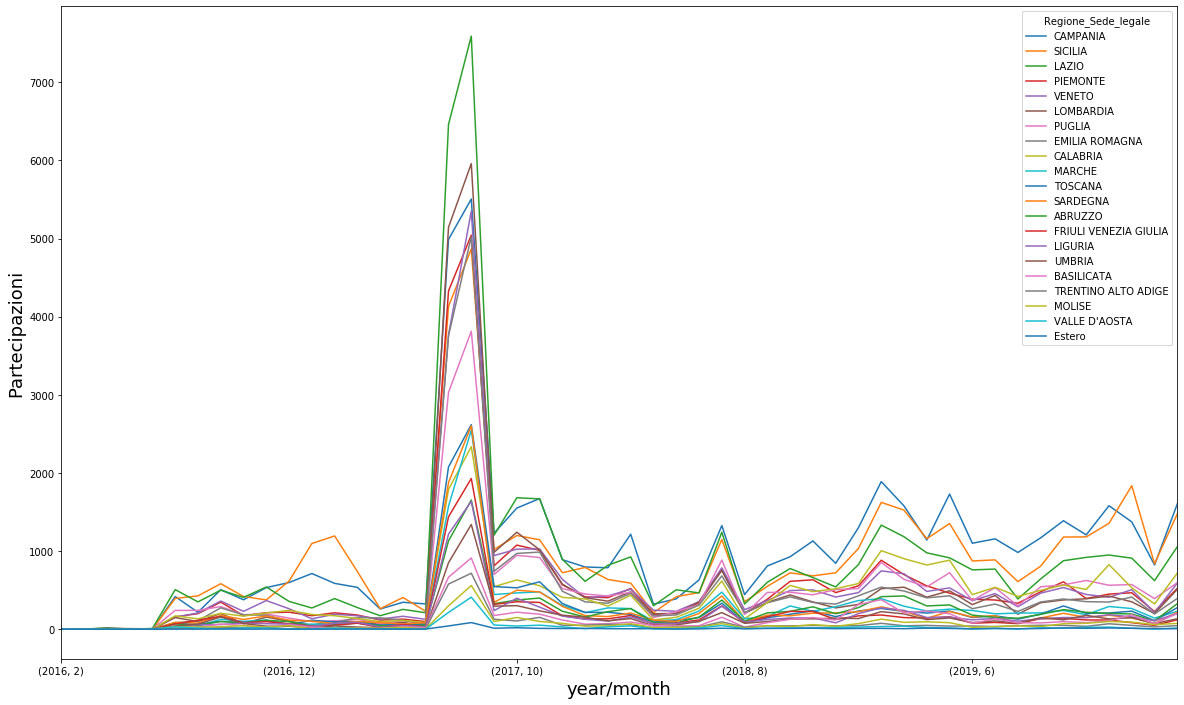

In [50]:
ax = count_by_region_month[count_by_region_month.index.get_level_values('Year') >= 2016].plot(figsize=(20, 12))
ax.set_xlabel('year/month', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)

In [51]:
top = 5
count_brq_top = count_by_region_month[count_by_region_month.sum(axis=0).sort_values(ascending=False)[:top].index]

Text(0, 0.5, 'Partecipazioni')

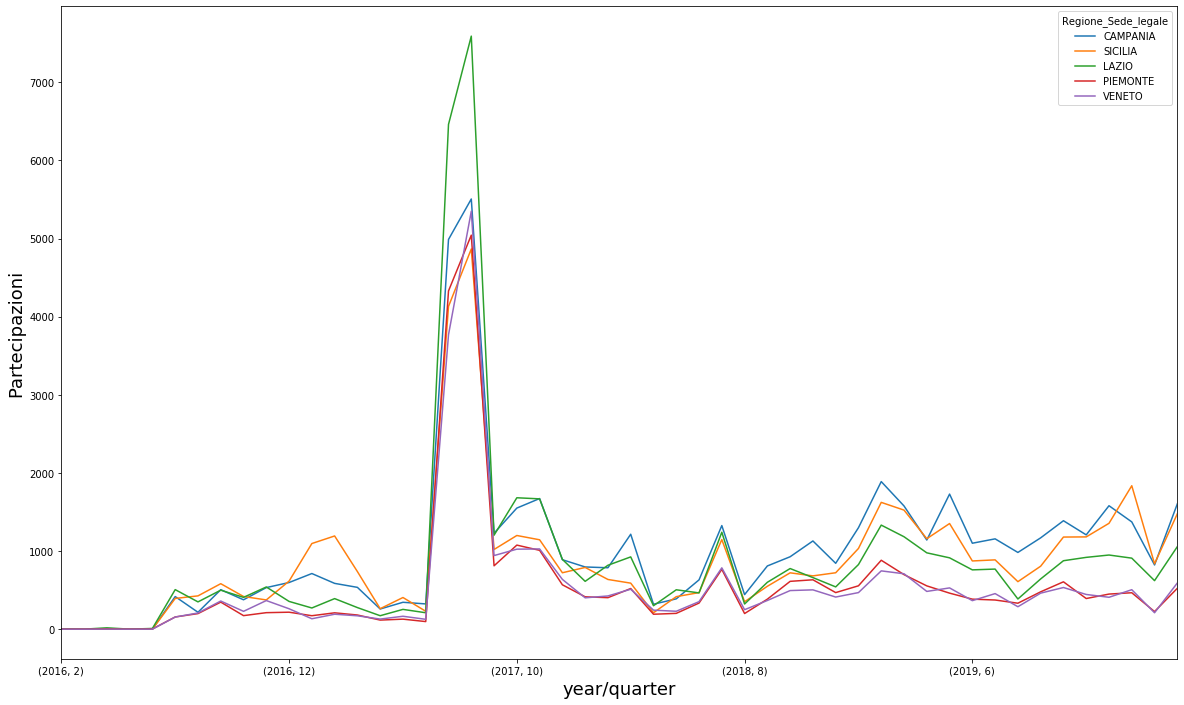

In [52]:
ax = count_brq_top[count_brq_top.index.get_level_values('Year') >= 2016].plot(figsize=(20, 12))
ax.set_xlabel('year/quarter', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)

### Total number of partecipazioni by quarter

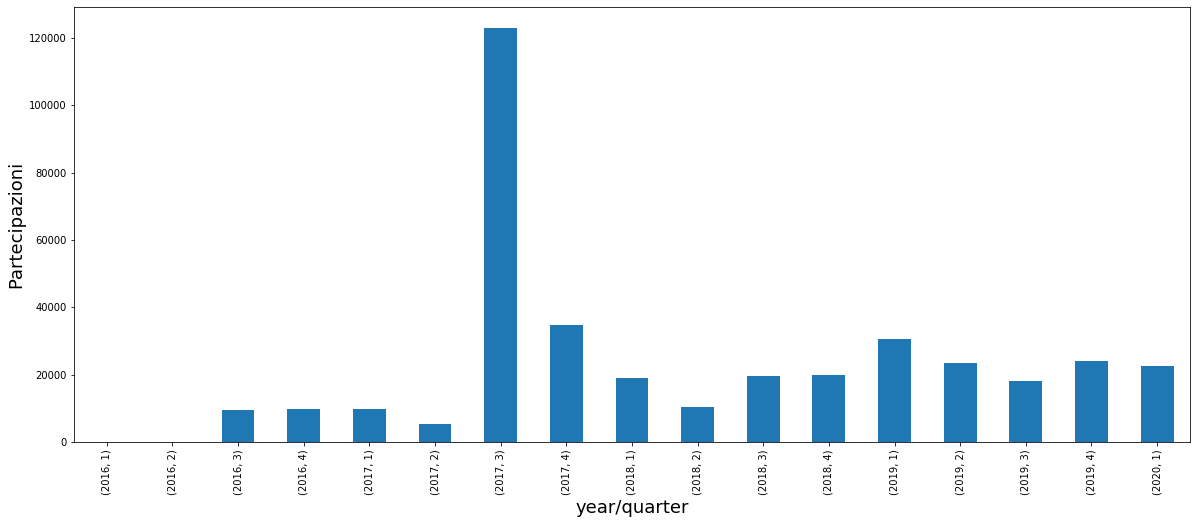

In [53]:
ax = count_by_quarter[count_by_quarter.index.get_level_values('Year') >= 2016].plot(linewidth=2, figsize=(20, 8), kind='bar')
ax.set_xlabel('year/quarter', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

In [54]:
top = 100
count_by_region_quarter = count_by_region_quarter[count_by_region_quarter.sum(axis=0).sort_values(ascending=False)[:top].index]

Text(0, 0.5, 'Partecipazioni')

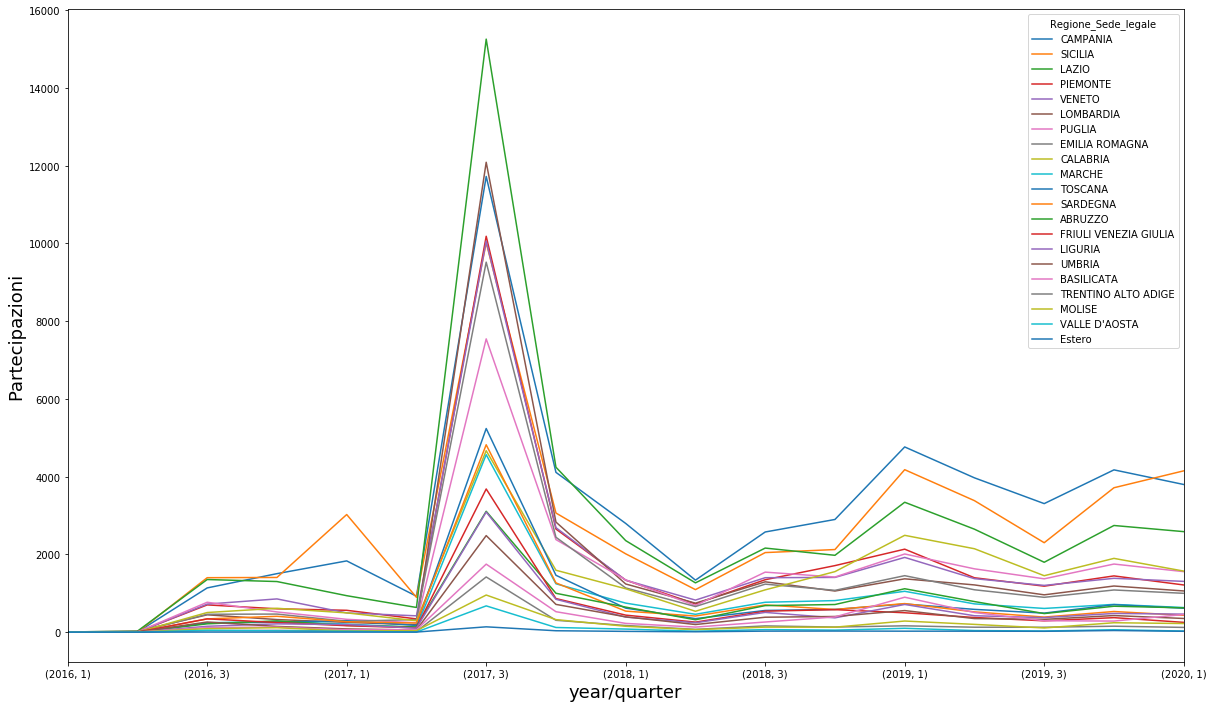

In [55]:
ax = count_by_region_quarter[count_by_region_quarter.index.get_level_values('Year') >= 2016].plot(figsize=(20, 12))
ax.set_xlabel('year/quarter', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)

In [56]:
top = 5
count_brq_top = count_by_region_quarter[count_by_region_quarter.sum(axis=0).sort_values(ascending=False)[:top].index]

Text(0, 0.5, 'Partecipazioni')

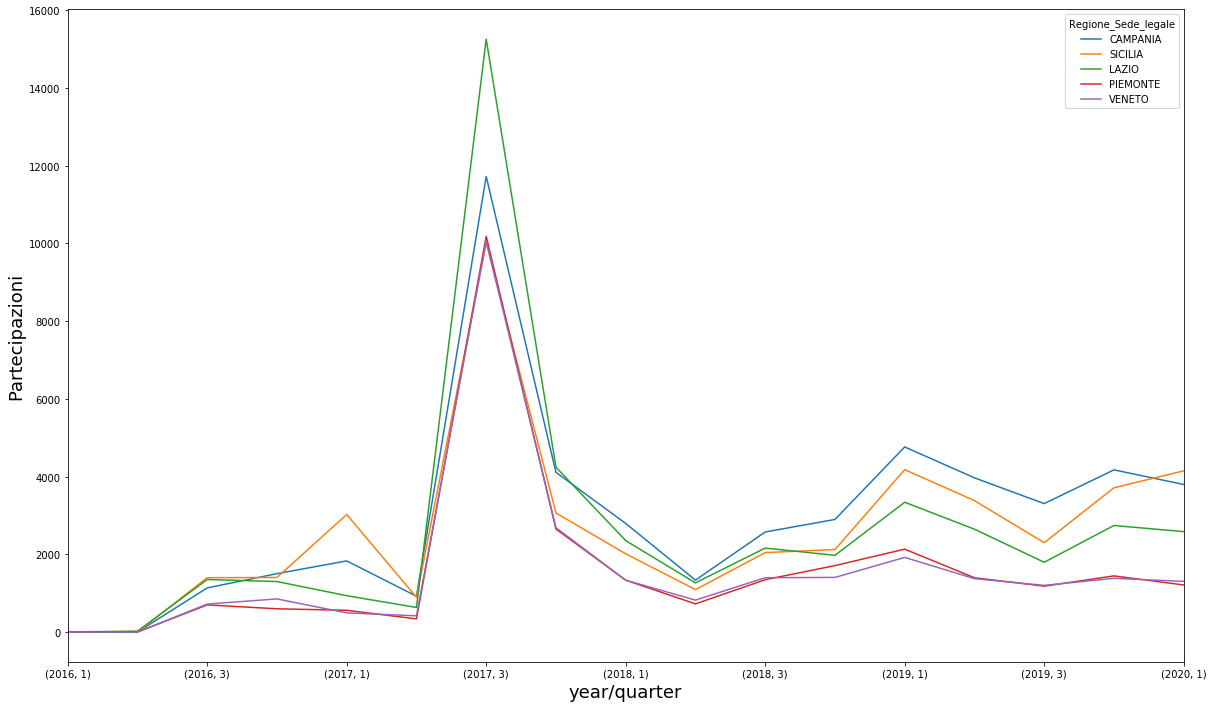

In [57]:
ax = count_brq_top[count_brq_top.index.get_level_values('Year') >= 2016].plot(figsize=(20, 12))
ax.set_xlabel('year/quarter', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)

# Model

### Load preprocessed data

In [30]:
df_merged = pd.read_csv('../data_processed/df_fornitori.csv')

### One hot encoding of categorical features

In [31]:
index_0 = 'Denominazione_Lotto' #  'Partita_Iva'

In [32]:
if index_0 == 'Partita_Iva':
    cat_toreduce = ['Denominazione_Iniziativa', 'Denominazione_Lotto', 'Provincia_Sede_legale']
    cat = ['Tipo_Strumento', 'Forma_Partecipazione', 'Flag_Capogruppo', 'Esito_Partecipazione',
       'Nazione_Sede_legale', 'Regione_Sede_legale', 'Forma_Societaria']
elif index_0 == 'Denominazione_Lotto':
    df_merged.drop('Partita_Iva', axis=1, inplace=True)
    cat_toreduce = ['Denominazione_Iniziativa', 'Provincia_Sede_legale']
    cat = ['Tipo_Strumento', 'Forma_Partecipazione', 'Flag_Capogruppo', 'Esito_Partecipazione',
       'Nazione_Sede_legale', 'Regione_Sede_legale', 'Forma_Societaria']

In [33]:
n = 20
for col in cat_toreduce + cat:
    if col in cat_toreduce:
        # reduce number of categories for features in cat_toreduce. 
        # keep only top n category and replace the rest under "other"
        top_10 = df_merged[col].value_counts()[:n]
        df_merged[col] = df_merged[col].apply(lambda x: x if x in top_10 else 'other')
    dummies = pd.get_dummies(df_merged[col], prefix=col)
    df_merged = df_merged.merge(dummies, left_index=True, right_index=True)
    df_merged.drop(col, axis=1, inplace=True)
df_merged.drop(['Data_Aggiudicazione/Abilitazione', 'Progressivo_Partecipante'], axis=1, inplace=True)

In [34]:
df_merged['Esito_Partecipazione_tot'] = df_merged['Esito_Partecipazione_Abilitato'] + df_merged['Esito_Partecipazione_Aggiudicatario'] + df_merged['Esito_Partecipazione_Non Aggiudicatario']

### Group by index_0, Year, month

In [43]:
if index_0 == 'Partita_Iva':
    prefix_sum = ['Denominazione_Iniziativa', 'Denominazione_Lotto',
          'Tipo_Strumento', 'Forma_Partecipazione', 'Flag_Capogruppo', 'Esito_Partecipazione']
    prefix_first = ['Nazione_Sede_legale', 'Regione_Sede_legale', 'Forma_Societaria', 'Provincia_Sede_legale']
    
elif index_0 == 'Denominazione_Lotto':
    prefix_sum = ['Denominazione_Iniziativa',
          'Tipo_Strumento', 'Forma_Partecipazione', 'Flag_Capogruppo', 'Esito_Partecipazione']
    prefix_first = ['Nazione_Sede_legale', 'Regione_Sede_legale', 'Forma_Societaria', 'Provincia_Sede_legale']

In [44]:
cols_sum = []
cols_first = []
for col in df_merged.columns:
    for prefix in prefix_sum:
        if prefix in col:
            cols_sum.append(col)
    for prefix in prefix_first:
        if prefix in col:
            cols_first.append(col)

In [45]:
agg_dict = {col: 'sum' if col in cols_sum else 'first' for col in cols_sum + cols_first}

In [46]:
agg_by = 'quarter' #  'month'

In [47]:
df_fin = df_merged.groupby([index_0, 'Year', agg_by]).agg(agg_dict)

In [48]:
df_fin.sort_values(['Year', agg_by], inplace=True)

In [49]:
df_fin

,,,Denominazione_Iniziativa_ARREDI,Denominazione_Iniziativa_BENI,Denominazione_Iniziativa_ENDOPROTESI ORTOPEDICHE E SISTEMI DI OSTEOSINTESI,Denominazione_Iniziativa_FARMACI,Denominazione_Iniziativa_FONTI RINNOVABILI ED EFFICIENZA ENERGETICA,Denominazione_Iniziativa_ICT - SDAPA,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - AMBIENTE E TERRITORIO,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - BENI DEL PATRIMONIO CULTURALE,Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - EDILI,"Denominazione_Iniziativa_LAVORI DI MANUTENZIONE - IDRAULICI, MARITTIMI E RETI GAS",...,Forma_Societaria_Rete di imprese,Forma_Societaria_Società Cooperativa,Forma_Societaria_Società a Responsabilità Limitata,Forma_Societaria_Società costituita in altro Stato Membro UE,Forma_Societaria_Società costituita in altro Stato extra UE,Forma_Societaria_Società in Accomandita Semplice,Forma_Societaria_Società in Accomandita per azioni,Forma_Societaria_Società in Nome Collettivo,Forma_Societaria_Società per Azioni,Forma_Societaria_Società semplice
Denominazione_Lotto,Year,quarter,,,,,,,,,,,,,,,,,,,,,
CAMPANIA,2011,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
EMILIA ROMAGNA,2011,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
LAZIO,2011,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
LOMBARDIA,2011,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
SERVIZIO INTEGRATO ENERGIA 2 - SARDEGNA,2011,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TROCAR OTTICI,2020,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
TROCAR SENZA LAMA,2020,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
TROCAR SENZA LAMA CALIBRO 15,2020,1,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


### Sanity check 

In [52]:
df_sample = df_fin[df_fin.index.get_level_values(index_0) == 'TROCAR SENZA LAMA']

In [53]:
df_sample[[col for col in df_fin.columns if 'Esito_Partecipazione' in col]]

,,,Esito_Partecipazione_Abilitato,Esito_Partecipazione_Aggiudicatario,Esito_Partecipazione_Non Aggiudicatario,Esito_Partecipazione_tot
Denominazione_Lotto,Year,quarter,,,,
TROCAR SENZA LAMA,2020,1,0.0,5,0,5.0


In [54]:
df_merged[df_merged['Denominazione_Lotto'] == 'TROCAR SENZA LAMA']

,Denominazione_Lotto,Denominazione_Partecipazione,Year,month,quarter,Denominazione_Iniziativa_ARREDI,Denominazione_Iniziativa_BENI,Denominazione_Iniziativa_ENDOPROTESI ORTOPEDICHE E SISTEMI DI OSTEOSINTESI,Denominazione_Iniziativa_FARMACI,Denominazione_Iniziativa_FONTI RINNOVABILI ED EFFICIENZA ENERGETICA,...,Forma_Societaria_Società Cooperativa,Forma_Societaria_Società a Responsabilità Limitata,Forma_Societaria_Società costituita in altro Stato Membro UE,Forma_Societaria_Società costituita in altro Stato extra UE,Forma_Societaria_Società in Accomandita Semplice,Forma_Societaria_Società in Accomandita per azioni,Forma_Societaria_Società in Nome Collettivo,Forma_Societaria_Società per Azioni,Forma_Societaria_Società semplice,Esito_Partecipazione_tot
378751,TROCAR SENZA LAMA,MEDI LINE S.R.L.,2020,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
378755,TROCAR SENZA LAMA,INNOVAMEDICA,2020,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
378908,TROCAR SENZA LAMA,JOHNSON & JOHNSON MEDICAL S.P.A.,2020,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
378917,TROCAR SENZA LAMA,B.BRAUN,2020,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
378925,TROCAR SENZA LAMA,MEDTRONIC ITALIA,2020,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [55]:
df_sample[[col for col in df_fin.columns if 'Forma_Societaria' in col]]

,,,Forma_Societaria_ASSOCIAZIONI/ENTI NON ONLUS,Forma_Societaria_AZIENDA CON PARTECIPAZIONE DI CAPITALE PUBBLICO e UNIVERSITA',"Forma_Societaria_Altro (Cooperativa Sociale, Fondazione, ...)",Forma_Societaria_Consorzio fra società cooperative di produzione e lavoro/Consorzio fra imprese artigiane,Forma_Societaria_Consorzio stabile,Forma_Societaria_Impresa Individuale,Forma_Societaria_ONLUS,Forma_Societaria_Professione non organizzata in ordini o collegi (cfr. L. 4/2013),Forma_Societaria_Professione organizzata (cfr. Art. 2229 cc),Forma_Societaria_Rete di imprese,Forma_Societaria_Società Cooperativa,Forma_Societaria_Società a Responsabilità Limitata,Forma_Societaria_Società costituita in altro Stato Membro UE,Forma_Societaria_Società costituita in altro Stato extra UE,Forma_Societaria_Società in Accomandita Semplice,Forma_Societaria_Società in Accomandita per azioni,Forma_Societaria_Società in Nome Collettivo,Forma_Societaria_Società per Azioni,Forma_Societaria_Società semplice
Denominazione_Lotto,Year,quarter,,,,,,,,,,,,,,,,,,,
TROCAR SENZA LAMA,2020,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [48]:
df_sample[[col for col in df_fin.columns if 'Denominazione_Lotto' in col]]

Denominazione_Lotto_ARREDI  \
Partita_Iva Year quarter                               
01698911003 2011 1                                 0   
            2012 2                                 0   
                 3                                 0   
            2014 3                                 0   
            2016 3                                 0   
            2017 3                                 0   
                 4                                 0   

                          Denominazione_Lotto_CANCELLERIA, CARTA, CONSUMABILI DA STAMPA E PRODOTTI PER IL RESTAURO  \
Partita_Iva Year quarter                                                                                             
01698911003 2011 1                                                        0                                          
            2012 2                                                        0                                          
                 3                                                        0                                          
            2014 3                                                        0                                          
            2016 3                                                        0                                          
            2017 3                                                        0                                          
                 4                                                        0                                          

                          Denominazione_Lotto_INFORMATICA, ELETTRONICA, TELECOMUNICAZIONI E MACCHINE PER UFFICIO  \
Partita_Iva Year quarter                                                                                           
01698911003 2011 1                                                        0                                        
            2012 2                                                        0                                        
                 3                                                        0                                        
            2014 3                                                        0                                        
            2016 3                                                        0                                        
            2017 3                                                        0                                        
                 4                                                        0                                        

                          Denominazione_Lotto_MATERIALI ELETTRICI, DA COSTRUZIONE, FERRAMENTA  \
Partita_Iva Year quarter                                                                        
01698911003 2011 1                                                        0                     
            2012 2                                                        0                     
                 3                                                        0                     
            2014 3                                                        0                     
            2016 3                                                        0                     
            2017 3                                                        0                     
                 4                                                        0                     

                          Denominazione_Lotto_OG1  Denominazione_Lotto_OG11  \
Partita_Iva Year quarter                                                      
01698911003 2011 1                              0                         0   
            2012 2                              0                         0   
                 3                              0                         0   
            2014 3                              0                         0   
            2016 3                              1                

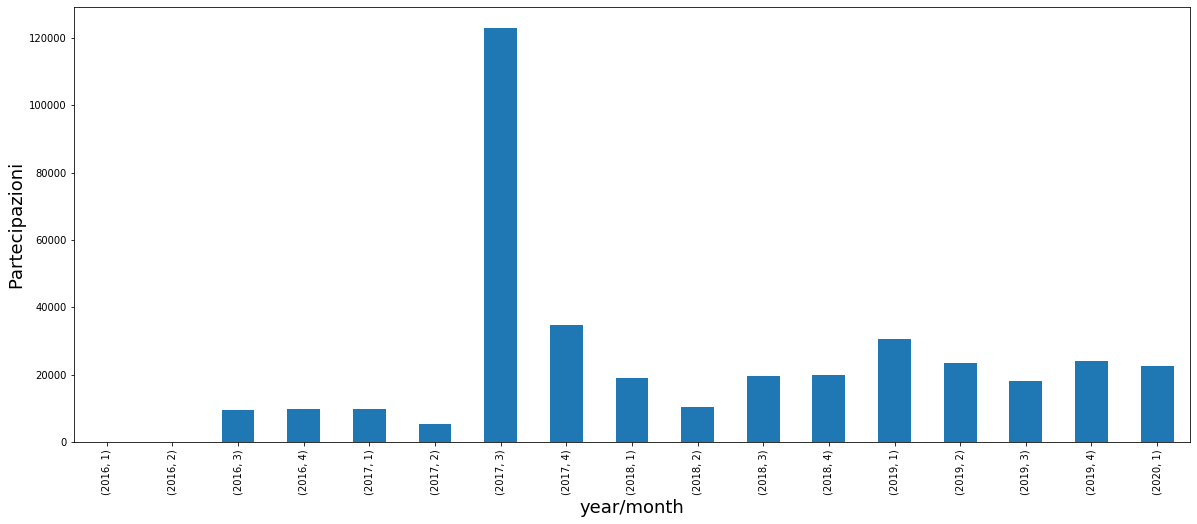

In [56]:
count_by = df_merged.groupby(['Year', 'quarter'])['Esito_Partecipazione_tot'].sum()
ax = count_by[count_by.index.get_level_values('Year') >= 2016].plot(linewidth=2, figsize=(20, 8), kind='bar')
ax.set_xlabel('year/month', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

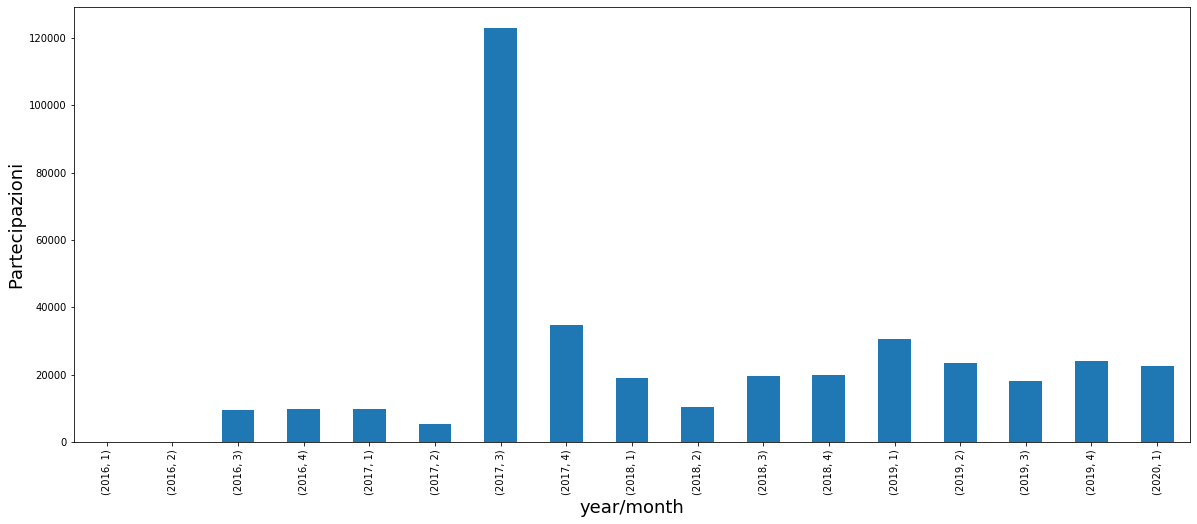

In [57]:
count_by = df_fin.groupby(['Year', 'quarter'])['Esito_Partecipazione_tot'].sum()
ax = count_by[count_by.index.get_level_values('Year') >= 2016].plot(linewidth=2, figsize=(20, 8), kind='bar')
ax.set_xlabel('year/month', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

### Build targets and preliminary model

In [543]:
df_fin_shift = df_fin.groupby('Partita_Iva')['Esito_Partecipazione_tot'].shift(-1)

In [552]:
df_fin['target'] = df_fin_shift

In [553]:
df_X = df_fin.dropna()

In [586]:
df_X['target'] = df_X['target'].apply(lambda x: 1 if x > 1 else 0)

In [606]:
df_X['target'].value_counts() / len(df_X)

0    0.625684
1    0.374316
Name: target, dtype: float64

In [587]:
df_X = df_X.reset_index()

In [588]:
df_X['Year'] = df_X['Year'].astype(int)

In [589]:
df_X_train = df_X[df_X['Year'] < 2019]

In [590]:
df_X_test = df_X[df_X['Year'] >= 2019]

In [591]:
X_train = df_X_train[[col for col in df_X_train.columns if col not in ['Partita_Iva', 'Year', 'month', 'target']]].values
X_test = df_X_test[[col for col in df_X_test.columns if col not in ['Partita_Iva', 'Year', 'month', 'target']]].values

In [592]:
y_train = df_X_train['target'].values
y_test = df_X_test['target'].values

In [596]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [594]:
xgb = XGBClassifier()

In [595]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [601]:
preds_train = xgb.predict(X_train)
preds_test = xgb.predict(X_test)

In [607]:
pd.Series(preds_train).value_counts()

0    38378
1     5419
dtype: int64

In [608]:
pd.Series(preds_test).value_counts()

0    4914
1    1936
dtype: int64

In [609]:
accuracy_score(y_train, preds_train)

0.6464598031828664

In [610]:
accuracy_score(y_test, preds_test)

0.6427737226277372

In [611]:
df_sample_shift = df_fin_shift[df_fin_shift.index.get_level_values('Partita_Iva') == '01698911003']

In [612]:
df_sample_shift

Partita_Iva  Year  month
01698911003  2011  01       1.0
             2012  05       3.0
                   09       1.0
             2014  09       4.0
             2016  08       9.0
                   09       1.0
             2017  07       1.0
                   09       3.0
                   10       NaN
Name: Esito_Partecipazione_tot, dtype: float64

In [613]:
df_sample['Esito_Partecipazione_tot']

Partita_Iva  Year  month
01698911003  2011  01       4
             2012  05       1
                   09       3
             2014  09       1
             2016  08       4
                   09       9
             2017  07       1
                   09       1
                   10       3
Name: Esito_Partecipazione_tot, dtype: uint8

----

In [342]:
df_merged = df_merged.merge(pd.get_dummies(df_merged['Esito_Partecipazione']), left_index=True, right_index=True)

In [343]:
df_merged['agg_abil'] = df_merged['Abilitato'] + df_merged['Aggiudicatario']

In [344]:
df_merged['cumcount'] = df_merged.groupby('Partita_Iva')['Esito_Partecipazione'].cumcount() + 1
df_merged['Abilitato_cumsum'] = df_merged.groupby('Partita_Iva')['Abilitato'].cumsum()
df_merged['Non Aggiudicatario_cumsum'] = df_merged.groupby('Partita_Iva')['Non Aggiudicatario'].cumsum()
df_merged['Aggiudicatario_cumsum'] = df_merged.groupby('Partita_Iva')['Aggiudicatario'].cumsum()
df_merged['agg_abil_cumsum'] = df_merged.groupby('Partita_Iva')['agg_abil'].cumsum()


In [346]:
df_merged[df_merged['Non Aggiudicatario'] == 1]

,#Denominazione_Iniziativa,Denominazione_Lotto,Tipo_Strumento,Partita_Iva,Ragione_Sociale,Forma_Partecipazione,Denominazione_Partecipazione,Progressivo_Partecipante,Flag_Capogruppo,Esito_Partecipazione,...,Forma_Societaria,Abilitato,Aggiudicatario,Non Aggiudicatario,agg_abil,cumcount,Abilitato_cumsum,Non Aggiudicatario_cumsum,Aggiudicatario_cumsum,agg_abil_cumsum
145358,CARTE DI CREDITO 5,PRESTAZIONE DEL SERVIZIO FINANZIARIO DI PAGAME...,Convenzione,04107060966,NEXI PAYMENTS S.P.A.,Singola,NEXI PAYMENTS S.P.A.,2,S,Non Aggiudicatario,...,Società per Azioni,0,0,1,0,1,0,1,0,0
401,AQ CARBURANTI RETE - FUEL CARD 1,LOTTO UNICO,Accordo Quadro,00891951006,KUWAIT PETROLEUM ITALIA S.P.A.,Singola,KUWAIT PETROLEUM ITALIA S.P.A.,1,S,Non Aggiudicatario,...,Società per Azioni,0,0,1,0,1,0,1,0,0
176213,GAS NATURALE 12,"EMILIA ROMAGNA, FRIULI VENEZIA GIULIA",Convenzione,01565370382,SOENERGY,Singola,SOENERGY,3,S,Non Aggiudicatario,...,Società a Responsabilità Limitata,0,0,1,0,6,0,1,5,5
176214,GAS NATURALE 12,LOMBARDIA,Convenzione,01565370382,SOENERGY,Singola,SOENERGY,3,S,Non Aggiudicatario,...,Società a Responsabilità Limitata,0,0,1,0,7,0,2,5,5
176215,GAS NATURALE 12,"VENETO, TRENTINO ALTO ADIGE",Convenzione,01565370382,SOENERGY,Singola,SOENERGY,2,S,Non Aggiudicatario,...,Società a Responsabilità Limitata,0,0,1,0,8,0,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382889,VEICOLI BLINDATI 3,VEICOLI FUORISTRADA,Convenzione,00326610375,VOLVO CAR ITALIA S.P.A.,Singola,VOLVO CAR ITALIA S.P.A.,2,S,Non Aggiudicatario,...,Società per Azioni,0,0,1,0,3,0,3,0,0
382890,VEICOLI PER LE FORZE DI SICUREZZA 2,FUORISTRADA,Convenzione,06070621005,JAGUAR LAND ROVER ITALIA,Singola,JAGUAR LAND ROVER ITALIA,3,S,Non Aggiudicatario,...,Società per Azioni,0,0,1,0,1,0,1,0,0
382891,VIDEOSORVEGLIANZA 1,SISTEMI DI VIDEOSORVEGLIANZA E SERVIZI CONNESS...,Convenzione,00490900305,AXIANS TELETRONICA SPA,Operatori Riuniti,TELETRONICA SPA -A.P. SYSTEMS SRL -SAIV SPA,4,S,Non Aggiudicatario,...,Società per Azioni,0,0,1,0,1,0,1,0,0
382892,VIDEOSORVEGLIANZA 1,SISTEMI DI VIDEOSORVEGLIANZA E SERVIZI CONNESS...,Convenzione,01534990054,SECURSAT SRL,Operatori Riuniti,GEMMO S.P.A. (SOCIETA' CON SOCIO UNICO),8,N,Non Aggiudicatario,...,Società a Responsabilità Limitata,0,0,1,0,1,0,1,0,0


In [281]:
df_merged['Partita_Iva'].value_counts()[df_merged['Partita_Iva'].value_counts() == 10]

00655840072    10
06647700720    10
01701580670    10
06754990825    10
05265721216    10
               ..
02980750786    10
05015921215    10
06385990723    10
09265311218    10
02293080509    10
Name: Partita_Iva, Length: 1027, dtype: int64

In [282]:
df_merged[df_merged['Partita_Iva'] == '00888380490']['Data_Aggiudicazione/Abilitazione']

7874   2017-07-29
7875   2017-07-29
7876   2017-07-29
7877   2017-07-29
7878   2017-07-29
7879   2017-07-29
7881   2017-08-03
7880   2017-08-03
7882   2017-08-03
7883   2017-08-03
Name: Data_Aggiudicazione/Abilitazione, dtype: datetime64[ns]

In [283]:
x = df_merged['Data_Aggiudicazione/Abilitazione'][0]

In [288]:
df_merged['Year'] = df_merged['Data_Aggiudicazione/Abilitazione'].map(lambda x: '{}'.format(x.year))
df_merged['month'] = df_merged['Data_Aggiudicazione/Abilitazione'].map(lambda x: '0{}'.format(x.month) 
                                                                       if x.month < 10 else '{}'.format(x.month) )

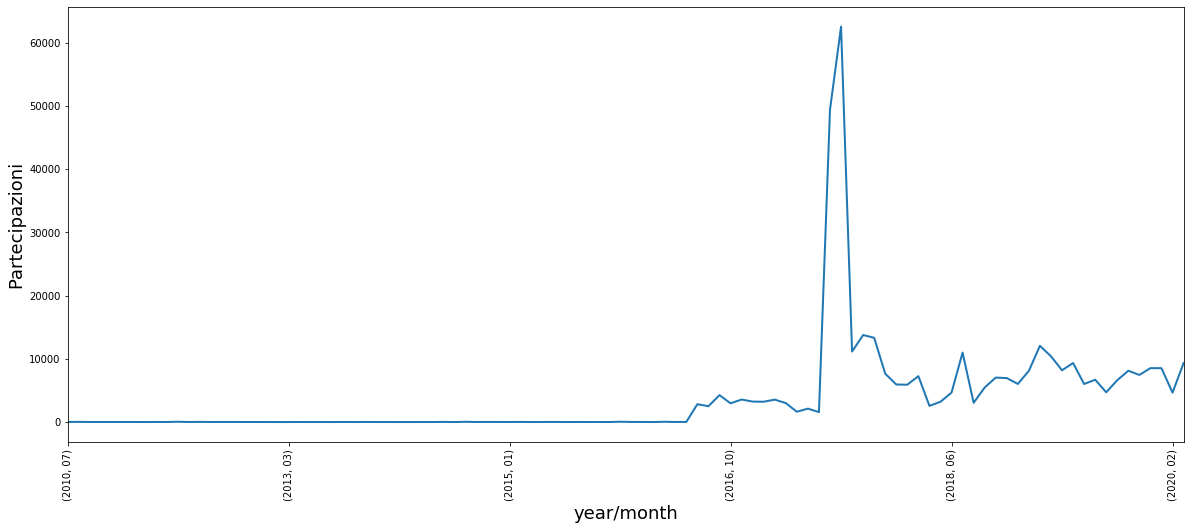

In [292]:
ax = count_by_month.plot(linewidth=2, figsize=(20, 8))
ax.set_xlabel('year/month', fontsize=18)
ax.set_ylabel('Partecipazioni', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small') 
    tick.label.set_rotation('vertical')

In [244]:
df_agg_bymonth = df_merged.groupby(['Partita_Iva', 'Year', 'month'])['agg_abil'].count().to_frame().reset_index()

In [245]:
df_agg_bymonth.rename(columns={'agg_abil': 'agg_abil_bymonth'}, inplace=True)

In [261]:
df_merged_bymonth = df_agg_bymonth[['Partita_Iva', 'agg_abil_bymonth']].merge(df_merged, on='Partita_Iva', right_index=True, left_index=True, how='inner')

In [262]:
df_merged_bymonth.columns

Index(['Partita_Iva', 'agg_abil_bymonth', '#Denominazione_Iniziativa',
       'Denominazione_Lotto', 'Tipo_Strumento', 'Ragione_Sociale',
       'Forma_Partecipazione', 'Denominazione_Partecipazione',
       'Progressivo_Partecipante', 'Flag_Capogruppo', 'Esito_Partecipazione',
       'Data_Aggiudicazione/Abilitazione', 'Regione_Sede_legale',
       'Provincia_Sede_legale', 'Comune_Sede_legale', 'Abilitato',
       'Aggiudicatario', 'Non Aggiudicatario', 'agg_abil', 'cumcount',
       'Abilitato_cumsum', 'Non Aggiudicatario_cumsum',
       'Aggiudicatario_cumsum', 'agg_abil_cumsum', 'Year', 'month'],
      dtype='object')

In [263]:
df_merged_bymonth = df_merged_bymonth.sort_values('Data_Aggiudicazione/Abilitazione')

In [264]:
df_merged_bymonth_red = df_merged_bymonth[['Partita_Iva', 'Esito_Partecipazione', 'agg_abil_cumsum', 'agg_abil', 'agg_abil_bymonth', 'Data_Aggiudicazione/Abilitazione', 'Year', 'month']]

In [293]:
df_merged_bymonth_red[df_merged_bymonth_red['Partita_Iva'] == '00001268887']

,Partita_Iva,Esito_Partecipazione,agg_abil_cumsum,agg_abil,agg_abil_bymonth,Data_Aggiudicazione/Abilitazione,Year,month
15,00001268887,Abilitato,19,1,4,2019-06-14,2019,6
11,00001268887,Abilitato,10,1,3,2019-06-14,2019,6
10,00001268887,Abilitato,12,1,2,2019-06-14,2019,6
12,00001268887,Abilitato,11,1,3,2019-06-14,2019,6
13,00001268887,Abilitato,17,1,1,2019-06-14,2019,6
14,00001268887,Abilitato,18,1,1,2019-06-14,2019,6


In [268]:
df_merged[df_merged['Partita_Iva'] == '02320810647']

,#Denominazione_Iniziativa,Denominazione_Lotto,Tipo_Strumento,Partita_Iva,Ragione_Sociale,Forma_Partecipazione,Denominazione_Partecipazione,Progressivo_Partecipante,Flag_Capogruppo,Esito_Partecipazione,...,Aggiudicatario,Non Aggiudicatario,agg_abil,cumcount,Abilitato_cumsum,Non Aggiudicatario_cumsum,Aggiudicatario_cumsum,agg_abil_cumsum,Year,month
52575,BENI,ATTREZZATURE E SEGNALETICA STRADALE,MePA,02320810647,GIRO SRL,Singola,GIRO SRL,2979,S,Abilitato,...,0,0,1,1,1,0,0,1,2018,1
52576,BENI,"MATERIALI ELETTRICI, DA COSTRUZIONE, FERRAMENTA",MePA,02320810647,GIRO SRL,Singola,GIRO SRL,8275,S,Abilitato,...,0,0,1,2,2,0,0,2,2018,1
52577,BENI,"TESSUTI, INDUMENTI (DPI E NON), EQUIPAGGIAMENT...",MePA,02320810647,GIRO SRL,Singola,GIRO SRL,4973,S,Abilitato,...,0,0,1,3,3,0,0,3,2018,1
52574,BENI,ARREDI,MePA,02320810647,GIRO SRL,Singola,GIRO SRL,7709,S,Abilitato,...,0,0,1,4,4,0,0,4,2018,1


In [233]:
s = df_agg_bymonth.groupby('Partita_Iva').count()

In [241]:
df_merged.columns

Index(['#Denominazione_Iniziativa', 'Denominazione_Lotto', 'Tipo_Strumento',
       'Partita_Iva', 'Ragione_Sociale', 'Forma_Partecipazione',
       'Denominazione_Partecipazione', 'Progressivo_Partecipante',
       'Flag_Capogruppo', 'Esito_Partecipazione',
       'Data_Aggiudicazione/Abilitazione', 'Regione_Sede_legale',
       'Provincia_Sede_legale', 'Comune_Sede_legale', 'Abilitato',
       'Aggiudicatario', 'Non Aggiudicatario', 'agg_abil', 'cumcount',
       'Abilitato_cumsum', 'Non Aggiudicatario_cumsum',
       'Aggiudicatario_cumsum', 'agg_abil_cumsum', 'Year', 'month'],
      dtype='object')

In [294]:
df_agg_bymonth[df_agg_bymonth['Partita_Iva'] == '00001268887']

,Partita_Iva,Year,month,agg_abil_bymonth
10,00001268887,2016,11,2
11,00001268887,2017,8,3
12,00001268887,2018,10,3
13,00001268887,2018,11,1
14,00001268887,2019,8,1
15,00001268887,2019,9,4


In [238]:
df_merged[df_merged['Partita_Iva'] == '00001268887'][['Data_Aggiudicazione/Abilitazione', 'agg_abil', 'agg_abil_cumsum']]

,Data_Aggiudicazione/Abilitazione,agg_abil,agg_abil_cumsum
264810,2016-11-25,1,1
264811,2016-11-25,1,2
264819,2017-08-22,1,3
264817,2017-08-22,1,4
264820,2017-08-22,1,5
264818,2018-10-31,1,6
264822,2018-10-31,1,7
264821,2018-10-31,1,8
264816,2018-11-07,1,9
264809,2019-08-09,1,10


In [212]:
df_merged[df_merged['Partita_Iva'] == 'SM26341']['Data_Aggiudicazione/Abilitazione']

29269   2017-08-03
29261   2017-08-03
29262   2017-08-03
29263   2017-08-03
29264   2017-08-03
29265   2017-08-03
29266   2017-08-03
29267   2017-08-03
29268   2017-08-03
Name: Data_Aggiudicazione/Abilitazione, dtype: datetime64[ns]

In [175]:
df_merged['agg_abil'].sum() / len(df)

0.9928048350672914

In [177]:
df_merged['Non Aggiudicatario'].sum() 

5

In [179]:
df_merged.Esito_Partecipazione.value_counts()

Abilitato             379163
Aggiudicatario          1116
Non Aggiudicatario         5
Name: Esito_Partecipazione, dtype: int64

In [104]:
abi_by_month[abi_by_month == abi_by_month.max()]

YearMonth
2017-08    62466.0
Name: Abilitato, dtype: float64

In [80]:
count_by_month[-10:]

YearMonth
201906    6014
201907    6692
201908    4701
201909    6617
201910    8109
201911    7441
201912    8522
202001    8513
202002    4646
202003    9306
Name: YearMonth, dtype: int64

In [58]:
min_date = df_merged['Data_Aggiudicazione/Abilitazione'].min()

In [59]:
max_date = df_merged['Data_Aggiudicazione/Abilitazione'].max()

In [45]:
trange = pd.date_range(min_date, max_date, freq='M')
trange

DatetimeIndex(['2010-07-31', '2010-08-31', '2010-09-30', '2010-10-31',
               '2010-11-30', '2010-12-31', '2011-01-31', '2011-02-28',
               '2011-03-31', '2011-04-30',
               ...
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31'],
              dtype='datetime64[ns]', length=117, freq='M')

In [ ]:
df

In [99]:
df_2019 = df_merged[(df_merged['Data_Aggiudicazione/Abilitazione'] >= pd.to_datetime('2000-01-01')) &
                   (df_merged['Data_Aggiudicazione/Abilitazione'] < pd.to_datetime('2019-12-31'))]

In [100]:
df_2019

,#Denominazione_Iniziativa,Denominazione_Lotto,Tipo_Strumento,Partita_Iva,Ragione_Sociale,Forma_Partecipazione,Denominazione_Partecipazione,Progressivo_Partecipante,Flag_Capogruppo,Esito_Partecipazione,Data_Aggiudicazione/Abilitazione,Regione_Sede_legale,Provincia_Sede_legale,Comune_Sede_legale
0,ACQUISTO AUTOBUS 2,AUTOBUS GRANDI,Convenzione,09709770011,IVECO SPA,Singola,IVECO SPA,1,S,Aggiudicatario,2015-09-15,PIEMONTE,TORINO,TORINO
1,ACQUISTO AUTOBUS 2,AUTOBUS PICCOLI,Convenzione,09709770011,IVECO SPA,Singola,IVECO SPA,2,S,Aggiudicatario,2015-09-15,PIEMONTE,TORINO,TORINO
2,ACQUISTO AUTOBUS 3,AUTOBUS EXTRA-URBANO LUNGO CON ALIMENTAZIONE A...,Convenzione,09709770011,IVECO SPA,Singola,IVECO S.P.A.,1,S,Aggiudicatario,2018-06-22,PIEMONTE,TORINO,TORINO
3,ACQUISTO AUTOBUS 3,AUTOBUS EXTRA-URBANO LUNGO CON ALIMENTAZIONE A...,Convenzione,09709770011,IVECO SPA,Singola,IVECO S.P.A.,1,S,Aggiudicatario,2018-06-22,PIEMONTE,TORINO,TORINO
4,ACQUISTO AUTOBUS 3,AUTOBUS EXTRA-URBANO NORMALE CON ALIMENTAZIONE...,Convenzione,09709770011,IVECO SPA,Singola,IVECO S.P.A.,1,S,Aggiudicatario,2018-06-22,PIEMONTE,TORINO,TORINO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390852,SERVIZIO LUCE 3,"PIEMONTE, VAL D'AOSTA, LOMBARDIA, LIGURIA",Convenzione,FR389643859,Citelum S.A.,Operatori Riuniti,"RTI - CITELUM S.A. , CO.GE.I SRL , EXITONE S.R...",3,S,Aggiudicatario,2015-11-06,Estero,Estero,Estero
390854,SERVIZIO LUCE 3,"TOSCANA, UMBRIA, MARCHE, EMILIA ROMAGNA",Convenzione,FR389643859,Citelum S.A.,Operatori Riuniti,"RTI - CO.GE.I SRL , CITELUM S.A. , CEIE POWER ...",3,S,Aggiudicatario,2014-09-18,Estero,Estero,Estero
390855,SERVIZIO LUCE 3,SARDEGNA,Convenzione,00291810182,EDILCILE S.R.L.,Operatori Riuniti,"RTI - EDILCILE SRL , PRIMA VERA S.P.A. , SEMAF...",3,N,Aggiudicatario,2014-09-18,LOMBARDIA,PAVIA,PAVIA
390860,STAMPANTI 14,"STAMPANTI IN B/N A 45/52 PAG/MIN, A4",Convenzione,01738750593,T.C.D.,Operatori Riuniti,INFORDATA_RTI_TCD,2,N,Aggiudicatario,2015-11-13,LAZIO,LATINA,LATINA


In [101]:
df_cat = pd.get_dummies(df_2019['Regione_Sede_legale'])
df_cat['Esito_Partecipazione'] = df_2019['Esito_Partecipazione']

In [102]:
df_cat.groupby('Esito_Partecipazione').sum()

,ABRUZZO,BASILICATA,CALABRIA,CAMPANIA,EMILIA ROMAGNA,Estero,FRIULI VENEZIA GIULIA,LAZIO,LIGURIA,LOMBARDIA,...,MOLISE,PIEMONTE,PUGLIA,SARDEGNA,SICILIA,TOSCANA,TRENTINO ALTO ADIGE,UMBRIA,VALLE D'AOSTA,VENETO
Esito_Partecipazione,,,,,,,,,,,,,,,,,,,,,
Abilitato,11317.0,6212.0,21435.0,50165.0,23819.0,410.0,9593.0,46030.0,8692.0,28210.0,...,3005.0,28450.0,25792.0,13396.0,42965.0,13513.0,3253.0,7345.0,1480.0,28157.0
Aggiudicatario,7.0,2.0,1.0,10.0,102.0,2.0,12.0,315.0,17.0,420.0,...,0.0,120.0,10.0,8.0,15.0,29.0,39.0,0.0,2.0,38.0
Non Aggiudicatario,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
df_f.groupby('Regione_Sede_legale')[[col for col in df_f.columns if 'Numero' in col]].sum()

,Numero_Aggiudicazioni,Numero_Abilitazioni,Numero_Transazioni,Numero_Contratti_attivi
Regione_Sede_legale,,,,
ABRUZZO,1,11529,11087,13388
BASILICATA,0,6315,3788,4965
CALABRIA,1,22324,14456,17217
CAMPANIA,0,51844,42890,50404
EMILIA ROMAGNA,15,24188,68545,88022
Estero,0,425,1739,2352
FRIULI VENEZIA GIULIA,1,9714,20422,25293
LAZIO,71,47019,111644,166639
LIGURIA,3,8880,13767,18324


In [38]:
df_cat = pd.get_dummies(df_merged['Regione_Sede_legale'])
df_cat['Esito_Partecipazione'] = df_merged['Esito_Partecipazione']

In [39]:
df_cat.groupby('Esito_Partecipazione').sum()

,ABRUZZO,BASILICATA,CALABRIA,CAMPANIA,EMILIA ROMAGNA,Estero,FRIULI VENEZIA GIULIA,LAZIO,LIGURIA,LOMBARDIA,...,MOLISE,PIEMONTE,PUGLIA,SARDEGNA,SICILIA,TOSCANA,TRENTINO ALTO ADIGE,UMBRIA,VALLE D'AOSTA,VENETO
Esito_Partecipazione,,,,,,,,,,,,,,,,,,,,,
Abilitato,10951.0,6087.0,22023.0,50872.0,23074.0,401.0,9018.0,44459.0,8544.0,26049.0,...,3084.0,27476.0,25096.0,12180.0,44826.0,12878.0,3063.0,7134.0,1379.0,27396.0
Aggiudicatario,5.0,2.0,3.0,12.0,95.0,4.0,10.0,296.0,12.0,418.0,...,0.0,111.0,10.0,8.0,12.0,32.0,38.0,0.0,2.0,39.0
Non Aggiudicatario,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
df_merged[df_merged['Partita_Iva'] == '03854991217']

,#Denominazione_Iniziativa,Denominazione_Lotto,Tipo_Strumento,Partita_Iva,Ragione_Sociale,Forma_Partecipazione,Denominazione_Partecipazione,Progressivo_Partecipante,Flag_Capogruppo,Esito_Partecipazione,Data_Aggiudicazione/Abilitazione,Regione_Sede_legale,Provincia_Sede_legale,Comune_Sede_legale,Abilitato,Aggiudicatario,Non Aggiudicatario,Abilitato_cumsum,Abilitato_cumcount
26945,BENI,ARREDI,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,2485,S,Abilitato,2017-07-31,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,1,1
26946,BENI,IMPIANTI E BENI PER LA PRODUZIONE DI ENERGIA D...,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,925,S,Abilitato,2017-07-31,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,2,2
26947,BENI,"MATERIALI ELETTRICI, DA COSTRUZIONE, FERRAMENTA",MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,2494,S,Abilitato,2017-07-31,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,3,3
26948,LAVORI DI MANUTENZIONE - EDILI,OG1,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,12504,S,Abilitato,2018-11-12,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,4,4
26949,LAVORI DI MANUTENZIONE - IMPIANTI,OG9,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,794,S,Abilitato,2017-02-23,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,5,5
26950,LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,OS28,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,937,S,Abilitato,2017-02-23,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,6,6
26951,LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,OS3,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,785,S,Abilitato,2017-02-23,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,7,7
26952,LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,OS30,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,630,S,Abilitato,2016-11-11,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,8,8
26953,LAVORI DI MANUTENZIONE - OPERE SPECIALIZZATE,OS5,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,268,S,Abilitato,2017-02-23,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,9,9
26954,SERVIZI,SERVIZI AGLI IMPIANTI (MANUTENZIONE E RIPARAZI...,MePA,03854991217,SF ELETTRICI S.R.L.,Singola,SF ELETTRICI S.R.L.,2375,S,Abilitato,2017-07-31,CAMPANIA,NAPOLI,AFRAGOLA,1,0,0,10,10
